## 2022 TBA Predictions

Match data is fetched from TBA by running fetchMatches.py.  Run this first before running this notebook.

`python fetchMatches.py`


In [36]:
from __future__ import print_function
import pickle
#import time
import sys
from collections import Counter

sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

fetch_matches = False
reset = False
if fetch_matches:
    from fetchMatches import fetch_all_matches
    # This will save to matches_2022.pkl
    fetch_all_matches(2022, reset=reset)


In [37]:
# load all the matches

filename = 'matches_2022.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)

In [38]:
# [m for m in matches['events'] if m.address and 'Spokane' in m.address]
[m for m in matches['events'] if 'pnc' in m.key]

[{'address': '526 5th St, Cheney, WA 99004, USA',
  'city': 'Cheney',
  'country': 'USA',
  'district': {'abbreviation': 'pnw',
               'display_name': 'Pacific Northwest',
               'key': '2022pnw',
               'year': 2022},
  'division_keys': [],
  'end_date': datetime.date(2022, 4, 9),
  'event_code': 'pncmp',
  'event_type': 2,
  'event_type_string': 'District Championship',
  'first_event_code': 'PNCMP',
  'first_event_id': None,
  'gmaps_place_id': 'ChIJ4z_DL6A4nlQRr2cmvozrjLU',
  'gmaps_url': 'https://maps.google.com/?cid=13082090007322585007',
  'key': '2022pncmp',
  'lat': 47.49102829999999,
  'lng': -117.5862361,
  'location_name': 'Eastern Washington University',
  'name': 'Pacific Northwest FIRST District Championship',
  'parent_event_key': None,
  'playoff_type': 0,
  'playoff_type_string': None,
  'postal_code': '99004',
  'short_name': 'Pacific Northwest FIRST',
  'start_date': datetime.date(2022, 4, 6),
  'state_prov': 'WA',
  'timezone': 'America/Los_

Filter the matches to completed matches

In [39]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='' and m.score_breakdown is not None]
print(len(data))
#red = [x for m in data for x in m.alliances.red.team_keys]
#blue = [x for m in data for x in m.alliances.blue.team_keys]
#from collections import Counter
#Counter(red+blue)

12240


Most match fields are numeric but some will need special treatment. Here we enumerate string and boolean fields.

In [40]:

data[0].score_breakdown['blue'].keys()

endgameFields = Counter()
taxiFields = Counter()
for d in data:
   try:
      endgameFields[d.score_breakdown['blue']['endgameRobot1']]+=1
      endgameFields[d.score_breakdown['blue']['endgameRobot2']]+=1
      endgameFields[d.score_breakdown['blue']['endgameRobot3']]+=1
      taxiFields[d.score_breakdown['blue']['taxiRobot1']]+=1
      taxiFields[d.score_breakdown['blue']['taxiRobot2']]+=1
      taxiFields[d.score_breakdown['blue']['taxiRobot3']]+=1
   except:
      print(d)
      raise
print(endgameFields)
print(taxiFields)

for k in d.score_breakdown['blue']:
   if type(d.score_breakdown['blue'][k]) is not int:
      print(k, type(d.score_breakdown['blue'][k]))


Counter({'None': 17940, 'Mid': 9264, 'Traversal': 5385, 'High': 2946, 'Low': 1185})
Counter({'Yes': 30245, 'No': 6475})
cargoBonusRankingPoint <class 'bool'>
endgameRobot1 <class 'str'>
endgameRobot2 <class 'str'>
endgameRobot3 <class 'str'>
hangarBonusRankingPoint <class 'bool'>
quintetAchieved <class 'bool'>
taxiRobot1 <class 'str'>
taxiRobot2 <class 'str'>
taxiRobot3 <class 'str'>


In [41]:
# Finals, quarterfinales, qualifiers, semifinals
Counter([x.comp_level for x in data])

Counter({'qf': 1156, 'qm': 10121, 'sf': 651, 'f': 312})

In [42]:
# We'll only train based on qualifier matches

qualifiers = [x for x in data if x.comp_level=='qm'] 

In [43]:
# ['adjustPoints', 'autoCargoLowerBlue', 'autoCargoLowerFar', 'autoCargoLowerNear', 'autoCargoLowerRed', 
# 'autoCargoPoints', 'autoCargoTotal', 'autoCargoUpperBlue', 'autoCargoUpperFar', 'autoCargoUpperNear', 
# 'autoCargoUpperRed', 'autoPoints', 'autoTaxiPoints', 'cargoBonusRankingPoint', 'endgamePoints', 
# 'endgameRobot1', 'endgameRobot2', 'endgameRobot3', 
# 'foulCount', 'foulPoints', 'hangarBonusRankingPoint', 'matchCargoTotal', 'quintetAchieved', 'rp', 
# 'taxiRobot1', 'taxiRobot2', 'taxiRobot3', 'techFoulCount', 
# 'teleopCargoLowerBlue', 'teleopCargoLowerFar', 'teleopCargoLowerNear', 'teleopCargoLowerRed', 
# 'teleopCargoPoints', 'teleopCargoTotal', 'teleopCargoUpperBlue', 'teleopCargoUpperFar', 'teleopCargoUpperNear', 
# 'teleopCargoUpperRed', 'teleopPoints', 'totalPoints']

# endgame: None': 6246, 'Mid': 2854, 'Traversal': 1177, 'High': 780, 'Low': 325}

teamAggregates = {}
pnwAggregates  = {}


import re
def matchAlliance(column, alliance):    
    m = re.match('(.*)(Red|Blue)', column)
    if m:
        if m.groups()[1].lower()==alliance:
            column = m.groups()[0]+'Same'
        else:
            column = m.groups()[0]+'Opp'        
    return column

def addMatch(team, m, aggregates):    
    if team not in aggregates:       
        # initialize an empty record for the team.
        aggregates[team]= {
            'plusMinus':0,
            'totalMatches':0, 
            'winCount': 0
        }
        for k in m.score_breakdown['blue'].keys():            
            val = m.score_breakdown['blue'][k]
            k = matchAlliance(k, 'blue')
            if type(val) is int or type(val) is bool:
                aggregates[team][f'{k}Total'] = 0            
            
        for r in [1,2,3]:
            for v in ['Yes', 'No']:
                aggregates[team][f'taxiRobot{r}{v}Total'] = 0
            for e in ['None', 'Mid', 'Traversal', 'High', 'Low']:
                aggregates[team][f'endgameRobot{r}{e}Total'] = 0 
        #for v in ['Yes', 'No']:
        #    aggregates[team][f'taxiRobotSelf{v}Total'] = 0
        #    aggregates[team][f'taxiRobotPartner{v}Total'] = 0
        
        #for e in ['None', 'Mid', 'Traversal', 'High', 'Low']:
        #    aggregates[team][f'endgameRobotSelf{e}Total'] = 0 
        #    aggregates[team][f'endgameRobotPartner{e}Total'] = 0 

    # TODO: we aren't accounting for alliance color when we 
    # accumulate fields like autoCargoUpperBlue/Red.  Does this matter? [need to read the rules]
    robotId = -1
    alliance = None
    oppalliance = None
    if team in m.alliances.blue.team_keys:
        alliance = 'blue'
        oppalliance = 'red'
        robotId = m.alliances.blue.team_keys.index(team)
    else:
        assert(team in m.alliances.red.team_keys)
        alliance = 'red'
        oppalliance = 'blue'
        robotId = m.alliances.red.team_keys.index(team)
    
    points = m.score_breakdown[alliance]
    summary = aggregates[team]
    # update all of the fields.
    summary['totalMatches']+=1    
    
    # TODO: figure out if we are robot 1, 2, or 3.
    for r in [1, 2, 3]:
        #q = 'Self' if r == robotId else 'Partner'        
        q = r
        summary[f'taxiRobot{q}{points[f"taxiRobot{r}"]}Total'] += 1
        summary[f'endgameRobot{q}{points[f"endgameRobot{r}"]}Total'] += 1

    for k in points.keys():
        if type(points[k]) is int:
            target = matchAlliance(k, alliance)
            summary[f'{target}Total'] += points[k]
        elif type(points[k]) is bool:
            summary[f'{k}Total'] += int(points[k])

    plusminus = points['teleopPoints'] + points['autoPoints'] \
        - m.score_breakdown[oppalliance]['teleopPoints'] - m.score_breakdown[oppalliance]['autoPoints']
    # summary['plusMinus'] += plusminus
    summary['winCount'] += int(m.winning_alliance==alliance)


for m in qualifiers:    
    for t in m.alliances.red.team_keys:
        addMatch(t, m, teamAggregates)
        if m.event_key == '2022pncmp':
            addMatch(t, m, pnwAggregates)
    for t in m.alliances.blue.team_keys:
        addMatch(t,m, teamAggregates)
        if m.event_key == '2022pncmp':
            addMatch(t, m, pnwAggregates)
        
# normalize the aggregates
def normalize(aggregates):
    for t in aggregates:
        for k in aggregates[t]:
            if k=='totalMatches':
                continue
            aggregates[t][k]/=aggregates[t]['totalMatches']
        aggregates[t]['totalMatches'] = 1.0

normalize(teamAggregates)
normalize(pnwAggregates)

with open('teamStats_2022.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [44]:
pnwAggregates['frc492']

{'plusMinus': 0.0,
 'totalMatches': 1.0,
 'winCount': 0.6666666666666666,
 'adjustPointsTotal': 0.0,
 'autoCargoLowerSameTotal': 0.0,
 'autoCargoLowerFarTotal': 0.25,
 'autoCargoLowerNearTotal': 0.16666666666666666,
 'autoCargoLowerOppTotal': 0.0,
 'autoCargoPointsTotal': 17.5,
 'autoCargoTotalTotal': 4.583333333333333,
 'autoCargoUpperSameTotal': 1.0,
 'autoCargoUpperFarTotal': 1.25,
 'autoCargoUpperNearTotal': 0.9166666666666666,
 'autoCargoUpperOppTotal': 1.0,
 'autoPointsTotal': 22.5,
 'autoTaxiPointsTotal': 5.0,
 'cargoBonusRankingPointTotal': 0.9166666666666666,
 'endgamePointsTotal': 21.25,
 'foulCountTotal': 0.6666666666666666,
 'foulPointsTotal': 3.0,
 'hangarBonusRankingPointTotal': 0.6666666666666666,
 'matchCargoTotalTotal': 26.666666666666668,
 'quintetAchievedTotal': 0.6666666666666666,
 'rpTotal': 2.9166666666666665,
 'techFoulCountTotal': 0.08333333333333333,
 'teleopCargoLowerSameTotal': 0.25,
 'teleopCargoLowerFarTotal': 0.5,
 'teleopCargoLowerNearTotal': 0.25,
 'tele

Now we have statistics for every team.  We can use this to generate features for every match.

In [45]:

def featurizeAlliances(red, blue, label=0, comp_level='qm', event='none', aggregates=teamAggregates):
    match_features = { 'red_missingCount':0, 'blue_missingCount': 0 }
    count=0    
    allKeys = set()
    for t in red:
        if t not in aggregates:
            match_features['red_missingCount']+=1
            continue
        for k in aggregates[t]:
            key = 'red_'+k
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=aggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    count=0
    allKeys=set()
    for t in blue:
        if t not in aggregates:
            match_features['blue_missingCount']+=1
            continue
        for k in aggregates[t]:
            key = 'blue_'+k
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=aggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    match_features['event']= event
    match_features['comp_level']= comp_level
    match_features['label']= label    
    return match_features

def featurizeMatch(m, aggregates=teamAggregates):
    return featurizeAlliances(
        m.alliances.red.team_keys, 
        m.alliances.blue.team_keys, 
        label=int(m.winning_alliance=='red'), # Positive label == red alliance won
        event = m.event_key, comp_level=m.comp_level,
        aggregates=aggregates)


def invertMatch(f):
    f2={}
    for k in f:
        k2 = k.replace('red_','temp_').replace('blue_','red_').replace('temp_','blue_')
        f2[k2]=f[k]
    f2['label']=1-f['label']
    return f2

features = []

for m in tqdm(data):
    f = featurizeMatch(m)
    features.append(f)
    #features.append(invertMatch(f))
    
features[0]


100%|██████████| 12240/12240 [00:03<00:00, 3861.28it/s]


{'red_missingCount': 0,
 'blue_missingCount': 0,
 'red_plusMinus': 0.0,
 'red_totalMatches': 1.0,
 'red_winCount': 0.7131944444444445,
 'red_adjustPointsTotal': 0.0,
 'red_autoCargoLowerSameTotal': 0.14305555555555557,
 'red_autoCargoLowerFarTotal': 0.10972222222222222,
 'red_autoCargoLowerNearTotal': 0.14375000000000002,
 'red_autoCargoLowerOppTotal': 0.09861111111111111,
 'red_autoCargoPointsTotal': 12.45972222222222,
 'red_autoCargoTotalTotal': 3.2895833333333333,
 'red_autoCargoUpperSameTotal': 0.7000000000000001,
 'red_autoCargoUpperFarTotal': 0.638888888888889,
 'red_autoCargoUpperNearTotal': 0.6236111111111111,
 'red_autoCargoUpperOppTotal': 0.8319444444444445,
 'red_autoPointsTotal': 17.634722222222223,
 'red_autoTaxiPointsTotal': 5.175,
 'red_cargoBonusRankingPointTotal': 0.6034722222222223,
 'red_endgamePointsTotal': 14.711805555555555,
 'red_foulCountTotal': 0.33958333333333335,
 'red_foulPointsTotal': 2.036111111111111,
 'red_hangarBonusRankingPointTotal': 0.496527777777777

In [46]:
len(features)

12240

In [47]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:    
    if 'event' not in m:
        print(m)
    event = m['event']
    comp_level = m['comp_level']
    del m['event']
    del m['comp_level']
    
    label = m['label']
    del m['label']
    
    # Train on qualifiers. Test on everything else.
    if comp_level!='qm':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)

print('{} training examples and {} test'.format(len(train),len(test)))


10121 training examples and 2119 test


In [48]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
forest_scores = classifier.predict_proba(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
print('accuracy: {}'.format(accuracy_score(testY, forest_predictions)))
#list(zip(forest_scores[:,1],testY))

# Save the model
model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'wb') as outF:
    pickle.dump((vectorizer,classifier), outF)


accuracy: 0.7843322321849929


Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:


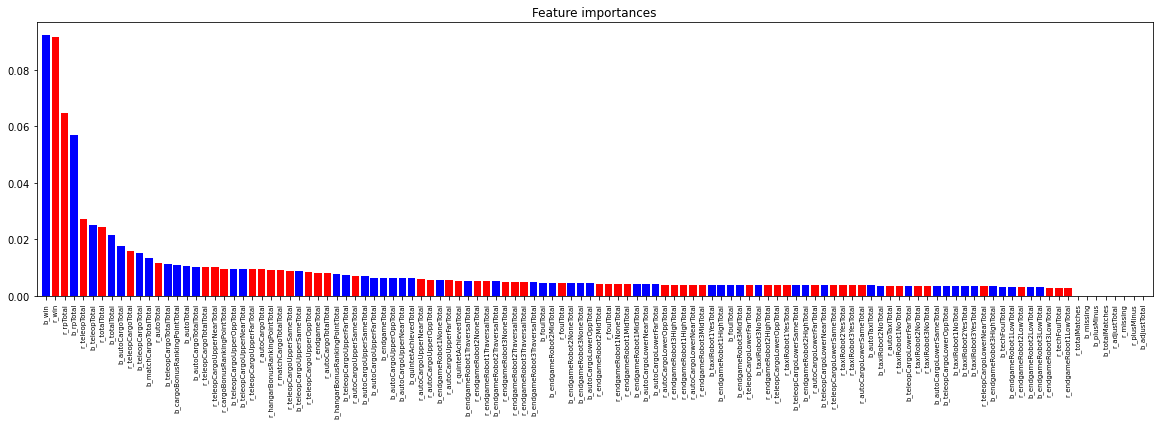

In [49]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(trainX.shape[1])]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(trainX.shape[1])]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), labels, rotation='vertical', fontsize='x-small')
    
plt.xlim([-1, trainX.shape[1]])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

In [50]:
def percentile(dictionary, key):
    teams = [t for t in dictionary]
    values = [dictionary[t][key] for t in dictionary]
    ranks = sorted(range(len(values)), key=lambda x: values[x])
    return dict([(teams[ranks[i]], i*100/len(values)) for i in range(len(ranks))])    

raw = dict([(k, percentile(teamAggregates,k)) for k in teamAggregates['frc1153']])
#stats = dict([(k,percentile(teamAggregates,k)['frc1153']) for k in teamAggregates['frc1153']])

The next cell enables comparisons between two teams.

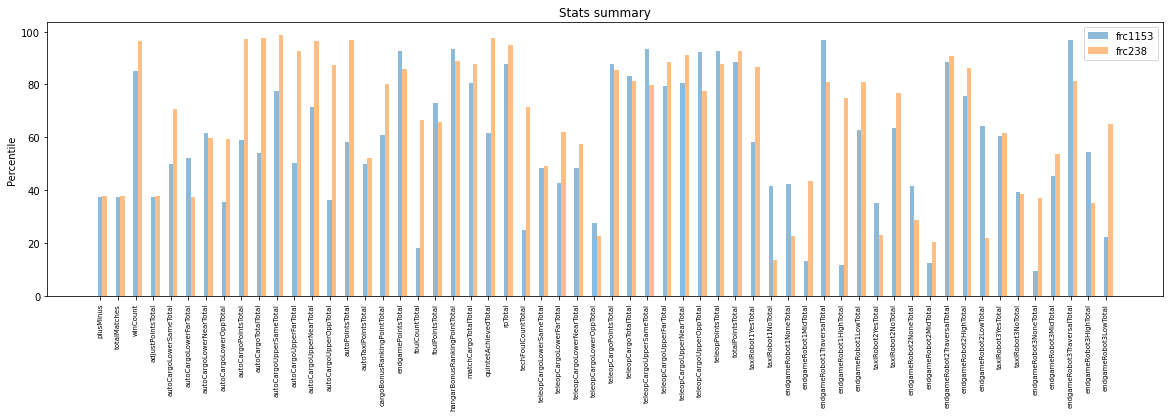

In [51]:
import matplotlib.pyplot as plt
import numpy as np

objects = [k for k in raw]
y_pos = np.arange(len(objects))
#performance = [[raw[k]['frc492'],raw[k]['frc2910']] for k in stats]
#performance
t1 = 'frc1153'
t2 = 'frc238'
plt.figure()
plt.bar(y_pos, [raw[k][t1] for k in raw], alpha=0.5, width=0.25)
plt.bar(y_pos+0.25, [raw[k][t2] for k in raw], alpha=0.5, width=0.25)
plt.xticks(y_pos, objects, rotation=90, fontsize='x-small')
plt.subplots_adjust(bottom=0.5)
plt.ylabel('Percentile')
plt.title('Stats summary')
plt.legend([t1,t2])

plt.show()


So far our best score at predicting the districts is 0.78 using either RandomForests.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.

Next steps: for a given event we want to decide how to prioritize alliance choices.  Suppose we have all the data to date, as well as all the qualifier data for the event. Who should we choose as partners?

In [52]:
# optimize alliances for frc492 at wasam on second pick:
import random
from tqdm import tqdm

event = '2022wasam'
teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])

model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# wasno
#taken_wasno = [
#    'frc2910', 'frc4089', 'frc7461', 'frc2930', 
#    'frc2522', 'frc4911', 'frc4512', 'frc492',
#    'frc7627', 'frc2903', 'frc4682', 'frc2412',
#    'frc1778', 'frc4173', 'frc2980', 'frc4131',
#    'frc3663', 'frc1899', 'frc5827', 'frc5588'
#]

taken_wasam_round1 = [
    4911, 5827, 488, 3218, 492
]

taken_wasam = [
    4911, 5827, 488, 3218, 492, 1899, 4180, 2928, 4915, 5588, 2412, 4173, 4205, 1983, 2980, 1318, 4469, 3786, 4512, 1778, 3681
]

taken = list(map(lambda x: f'frc{x}', taken_wasam))

# set to just ['frc492'] if you're ranking pairs
target = ['frc492']
# target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    trials = 1000
    
    for m in range(trials):
        # Here we're sampling any possible alliance, except the members of red.    
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(red, blue)
        features.append(f)
        alliances.append([red,blue])

# run all the simulated matches through the model
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    


for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


('frc492', 'frc1294', 'frc4682') 694.3643333333348
('frc492', 'frc1294', 'frc3049') 670.8138333333321
('frc492', 'frc1294', 'frc7627') 668.8929999999999
('frc492', 'frc1294', 'frc5683') 667.4078333333337
('frc492', 'frc1294', 'frc949') 642.1565000000015
('frc492', 'frc1294', 'frc4579') 629.1796666666663
('frc492', 'frc1294', 'frc948') 621.9959999999995
('frc492', 'frc1294', 'frc4309') 614.7733333333349
('frc492', 'frc1294', 'frc2929') 589.2246666666668
('frc492', 'frc3049', 'frc4682') 498.0693333333333
('frc492', 'frc4682', 'frc5683') 467.99766666666716
('frc492', 'frc4579', 'frc4682') 459.6958333333339
('frc492', 'frc3049', 'frc7627') 455.25833333333384
('frc492', 'frc4682', 'frc7627') 455.0375000000001
('frc492', 'frc4682', 'frc949') 446.1311666666666
('frc492', 'frc3049', 'frc949') 444.1958333333342
('frc492', 'frc3049', 'frc5683') 427.9228333333328
('frc492', 'frc4309', 'frc4682') 424.16633333333334
('frc492', 'frc7627', 'frc948') 420.68983333333347
('frc492', 'frc2929', 'frc4682')

In [53]:
# Districts
import random
from tqdm import tqdm

# Districts event key is '2022pncmp': update this on Friday night
event = '2022pncmp'

# Fetch the event rankings so far.
from fetchMatches import fetch_event_rankings
rankings = fetch_event_rankings(event)

print([(r.rank, r.team_key) for r in rankings.rankings])
teams = [r.team_key for r in rankings.rankings]

rank_492 = [r.rank for r in rankings.rankings if r.team_key=='frc492'][0]
prior_taken = teams[:rank_492]
print(prior_taken)
teams_ahead = rank_492-1
all_taken = teams[:rank_492+teams_ahead]
print(all_taken)

rankings_dict = dict([(r.team_key, r.rank) for r in rankings.rankings])

[(1, 'frc2910'), (2, 'frc2976'), (3, 'frc2471'), (4, 'frc2147'), (5, 'frc1595'), (6, 'frc4911'), (7, 'frc2930'), (8, 'frc997'), (9, 'frc4488'), (10, 'frc955'), (11, 'frc2046'), (12, 'frc3674'), (13, 'frc4512'), (14, 'frc957'), (15, 'frc2811'), (16, 'frc2521'), (17, 'frc492'), (18, 'frc2557'), (19, 'frc7034'), (20, 'frc6350'), (21, 'frc3711'), (22, 'frc4089'), (23, 'frc2522'), (24, 'frc3663'), (25, 'frc3218'), (26, 'frc360'), (27, 'frc7461'), (28, 'frc2990'), (29, 'frc5827'), (30, 'frc1540'), (31, 'frc1425'), (32, 'frc3636'), (33, 'frc4131'), (34, 'frc488'), (35, 'frc6831'), (36, 'frc1899'), (37, 'frc4513'), (38, 'frc4125'), (39, 'frc1294'), (40, 'frc2928'), (41, 'frc1359'), (42, 'frc4915'), (43, 'frc5920'), (44, 'frc3786'), (45, 'frc2412'), (46, 'frc2635'), (47, 'frc568'), (48, 'frc4043'), (49, 'frc8248'), (50, 'frc8532')]
['frc2910', 'frc2976', 'frc2471', 'frc2147', 'frc1595', 'frc4911', 'frc2930', 'frc997', 'frc4488', 'frc955', 'frc2046', 'frc3674', 'frc4512', 'frc957', 'frc2811', 'f

In [54]:
# This cell continues with the event key set above.

teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])
print(teams)
model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# Set to include only 492 when we just want to rank all the potential alliances.
taken = [
    492
]


taken = list(map(lambda x: f'frc{x}', taken))

# set to just ['frc492'] if you're ranking pairs, ['frc492', 'first choice partner'] if you want to rank second choices.
target = ['frc492']
# target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
trials = 1000
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    
    for m in range(trials):
        # Here we're sampling any possible alliance, except the members of red.    
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(red, blue)
        features.append(f)
        alliances.append([red,blue])

# run all the simulated matches through the model
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    

for p in results:
    results[p] = results[p] * 100 / trials

for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

{'frc4915', 'frc2521', 'frc488', 'frc4488', 'frc2147', 'frc6350', 'frc4512', 'frc957', 'frc4125', 'frc2471', 'frc2910', 'frc3674', 'frc4911', 'frc7034', 'frc8532', 'frc4513', 'frc2976', 'frc1899', 'frc1294', 'frc3786', 'frc8248', 'frc1540', 'frc6831', 'frc2990', 'frc4131', 'frc3636', 'frc7461', 'frc492', 'frc2635', 'frc5920', 'frc3663', 'frc1359', 'frc2412', 'frc997', 'frc955', 'frc1425', 'frc4043', 'frc4089', 'frc2930', 'frc360', 'frc5827', 'frc2811', 'frc3218', 'frc2522', 'frc2046', 'frc568', 'frc1595', 'frc2928', 'frc2557', 'frc3711'}


100%|██████████| 1176/1176 [06:26<00:00,  3.04it/s]


('frc492', 'frc2046', 'frc2910') 79.76581904761906
('frc492', 'frc2910', 'frc3218') 79.5488571428573
('frc492', 'frc2910', 'frc7034') 79.36853333333345
('frc492', 'frc2471', 'frc2910') 79.27851666666692
('frc492', 'frc2910', 'frc955') 79.12708333333346
('frc492', 'frc2910', 'frc2990') 78.84992619047625
('frc492', 'frc2910', 'frc4911') 78.29358333333336
('frc492', 'frc2811', 'frc2910') 77.9730833333336
('frc492', 'frc2910', 'frc7461') 77.93716666666677
('frc492', 'frc2910', 'frc4089') 77.75150000000008
('frc492', 'frc2046', 'frc4089') 77.72245000000008
('frc492', 'frc2910', 'frc2930') 77.69426666666664
('frc492', 'frc1540', 'frc2910') 77.38535714285732
('frc492', 'frc4089', 'frc4911') 77.06278333333344
('frc492', 'frc4089', 'frc7034') 77.00966666666683
('frc492', 'frc2910', 'frc5827') 76.81661666666673
('frc492', 'frc2046', 'frc2990') 76.66945238095248
('frc492', 'frc2910', 'frc957') 76.6521666666668
('frc492', 'frc2046', 'frc4911') 76.59938095238108
('frc492', 'frc2910', 'frc3636') 76.

In [55]:

with open('alliance_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('a1,a2,a3,p(win),rank1,rank2,rank3\n')
    for (a1,a2,a3) in list(sorted(results, key=lambda x: results[x], reverse=True)):
        outF.write('{},{},{},{},{},{},{}\n'.format(a1,a2,a3,results[(a1,a2,a3)], rankings_dict[a1], rankings_dict[a2], rankings_dict[a3]))

ranks = {}
for r in results:
    for a in r[1:]:
        if a not in ranks:
            ranks[a] = 0
        ranks[a]+=results[r]
with open('team_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('team,score,pnw_rank\n')
    for a in sorted(ranks, key=lambda x: ranks[x], reverse=True):
        outF.write('{},{},{}\n'.format(a,ranks[a], rankings_dict[a]))


In [56]:
# One more using only districts stats
# This cell continues with the event key set above.

teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])
print(teams)
model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# Set to include only 492 when we just want to rank all the potential alliances.
taken = [
    492
]


taken = list(map(lambda x: f'frc{x}', taken))

# set to just ['frc492'] if you're ranking pairs, ['frc492', 'first choice partner'] if you want to rank second choices.
target = ['frc492']
# target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
trials = 1000
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    
    for m in range(trials):
        # Here we're sampling any possible alliance, except the members of red.    
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(red, blue, aggregates=pnwAggregates)
        features.append(f)
        alliances.append([red,blue])

# run all the simulated matches through the model
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    

for p in results:
    results[p] = results[p] * 100 / trials

for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

{'frc4915', 'frc2521', 'frc488', 'frc4488', 'frc2147', 'frc6350', 'frc4512', 'frc957', 'frc4125', 'frc2471', 'frc2910', 'frc3674', 'frc4911', 'frc7034', 'frc8532', 'frc4513', 'frc2976', 'frc1899', 'frc1294', 'frc3786', 'frc8248', 'frc1540', 'frc6831', 'frc2990', 'frc4131', 'frc3636', 'frc7461', 'frc492', 'frc2635', 'frc5920', 'frc3663', 'frc1359', 'frc2412', 'frc997', 'frc955', 'frc1425', 'frc4043', 'frc4089', 'frc2930', 'frc360', 'frc5827', 'frc2811', 'frc3218', 'frc2522', 'frc2046', 'frc568', 'frc1595', 'frc2928', 'frc2557', 'frc3711'}


100%|██████████| 1176/1176 [06:17<00:00,  3.12it/s]


('frc492', 'frc1595', 'frc488') 45.47956666666662
('frc492', 'frc2147', 'frc4131') 45.247983333333345
('frc492', 'frc1595', 'frc4131') 45.24178333333331
('frc492', 'frc2910', 'frc2930') 45.239600000000024
('frc492', 'frc2147', 'frc2928') 45.14023333333334
('frc492', 'frc2910', 'frc3218') 45.13399999999998
('frc492', 'frc3711', 'frc6350') 45.03214999999994
('frc492', 'frc2910', 'frc2928') 45.00574999999996
('frc492', 'frc2910', 'frc997') 44.989250000000055
('frc492', 'frc2147', 'frc488') 44.9666833333333
('frc492', 'frc1899', 'frc2147') 44.7763833333333
('frc492', 'frc2147', 'frc2910') 44.751649999999934
('frc492', 'frc2910', 'frc955') 44.74638333333332
('frc492', 'frc2976', 'frc4915') 44.6966666666667
('frc492', 'frc1595', 'frc2910') 44.647316666666704
('frc492', 'frc2910', 'frc7461') 44.61164999999997
('frc492', 'frc2910', 'frc957') 44.55671666666662
('frc492', 'frc1595', 'frc2147') 44.475266666666705
('frc492', 'frc2046', 'frc7034') 44.40300000000002
('frc492', 'frc4131', 'frc997') 4

In [57]:

with open('pnw_alliance_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('a1,a2,a3,p(win),rank1,rank2,rank3\n')
    for (a1,a2,a3) in list(sorted(results, key=lambda x: results[x], reverse=True)):
        outF.write('{},{},{},{},{},{},{}\n'.format(a1,a2,a3,results[(a1,a2,a3)], rankings_dict[a1], rankings_dict[a2], rankings_dict[a3]))

ranks = {}
for r in results:
    for a in r[1:]:
        if a not in ranks:
            ranks[a] = 0
        ranks[a]+=results[r]
with open('pnw_team_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('team,score,pnw_rank\n')
    for a in sorted(ranks, key=lambda x: ranks[x], reverse=True):
        outF.write('{},{},{}\n'.format(a,ranks[a], rankings_dict[a]))

In [67]:
# Brackets
wins = Counter()

trials = 1000
for t in tqdm(range(trials)):
    # TODO: download from TBA
    brackets = list(map(lambda x: list(map(lambda y: f'frc{y}', x)),
        [
            (4911, 2910, 3218),
            (2990, 955, 360),
            (5827, 2147, 2557),
            (4089, 1595, 3663),
            (2046, 2976, 488),
            (7034, 997, 1899),
            (4488, 2471, 2522),
            (3636, 2930, 3674)
        ]))

    while len(brackets)>1:
        alliances = []
        features = []
        for x in range(0,len(brackets),2):
            red = brackets[x]
            blue = brackets[x+1]
            #print(red,blue)
            f = featurizeAlliances(red, blue, aggregates=teamAggregates)       
            features.append(f)
            alliances.append([red,blue])

        # run all the simulated matches through the model
        scores = model.predict_proba(vectorizer.transform(features))
        results = {}
        next_round = []
        for (r,b), score in zip(alliances, scores): 
            #print(r,b,score)
            #if score[1]>score[0]:
            if random.random()<score[1]:
                next_round.append(r)
            else:
                next_round.append(b)
        brackets = next_round
        #print(brackets)
    wins[tuple(brackets[0])]+=1
for x in sorted(wins, reverse=True, key=lambda x: wins[x]):
    print(f'{tuple(map(lambda y: y[3:], x))} {wins[x]/10}%')

100%|██████████| 1000/1000 [00:44<00:00, 22.53it/s]

('frc3636', 'frc2930', 'frc3674') 285
('frc4911', 'frc2910', 'frc3218') 137
('frc4488', 'frc2471', 'frc2522') 135
('frc2990', 'frc955', 'frc360') 127
('frc2046', 'frc2976', 'frc488') 107
('frc4089', 'frc1595', 'frc3663') 107
('frc5827', 'frc2147', 'frc2557') 64
('frc7034', 'frc997', 'frc1899') 38
